In [14]:
import evaluate
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import os
import json
import re

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoConfig
)

### Chunking process

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


["P1: I've had it! I am done working for a company that is taking me nowhere!\nP2: So what are you gonna do? Just quit?\nP1: That's exactly what I am going to do! I have decided to create my own company! I am going to write up a business plan, get some investors and start working for myself!\nP2: Have you ever written up a business plan before?", "P1: Well, no, it can't be that hard! I mean, all you have to do is explain your business, how you are going to do things and that's it, right?\nP2: You couldn't be more wrong! A well written business plan will include an executive summary which highlights the idea of the business in two pages or less. Then you need to describe your company with information such as what type of legal structure it has, history, etc.", 'P1: Well, that seems easy enough.', 'P2: Wait, there is more!. Then you need to introduce and describe your goods or services.. What they are and how they are different from competitors?. Then comes the hard part, a market analys

### Génération des key points

JSONDecodeError: Expecting ',' delimiter: line 28 column 9328 (char 61716)

In [25]:
s = ["J'aimerais bien sûr, bonjour.\\nOooYeaaah. That's for sure.", "I'd like to see how it goes.\\nYeah man !"]
file = open("test.txt", 'w', encoding = 'utf-8')
file.write('\n'.join(s))
file.close()


### Identification des bullet points

In [4]:
lines = [
    "Here are some key points from this article:",
    "1.  Fiji Water is a bottled water brand that is very popular in the United States.  It is owned by an American couple, and is produced in Fiji.  However, the company nearly closed its Fiji operations after the Fijian government increased the tax on water extraction.",
    "Here are some key points from the interview:",
    "- Fiji Water is a bottled water brand that is owned by a California couple and is produced in Fiji.",
    "Here are some key points from this text:",
    "-Fiji Water is a bottled water brand that is popular in the United States.  It is owned by an American couple and is produced in Fiji."
]

MAX_CHARACTER_CHUNK_SIZE = 6000

def token_len(text):
    return len(tokenizer(text, return_tensors="pt")['input_ids'][0])

def append_to_chunk(current_chunk, utterance):
    if len(current_chunk) > 0:
        current_chunk += '\n'
    current_chunk += utterance
    return current_chunk

def chunkize(text):
    """
    Greedy implementation of a dialogue transcript chunking algorithm. This method returns a list of transcript chunks.
    - It priorities stability over performance. There is a set maximum chunk size for LLM inference stability. Really long utterances bypass this limit.
    - It guarantees the cuts are made at utterance ends (\n).
    - It counts everything in MODEL TOKENS and not characters for more exact experiments.
    """
    
    chunks = [] # Final list of transcript chunks. This makes up the loop invariant
    utterances = text.split('\n') # Transcript is split into sentences
    utterances.reverse() # Reverse everything!!
    current_chunk = ''

    # While there is still an utterance to process
    while len(utterances) > 0:
        utterance = utterances.pop()

        # Add to current chunk and proceed to next
        new_current_chunk = append_to_chunk(current_chunk, utterance)
        if token_len(new_current_chunk) <= MAX_CHARACTER_CHUNK_SIZE:
            current_chunk = new_current_chunk
        
        # Utterance is larger than maximum chunk size
        elif len(current_chunk) == 0:
            chunks.append(current_chunk)
            chunks.append(utterance)
            current_chunk = ''

        # Current chunk is big enough, append to list and create new one
        else:
            chunks.append(current_chunk)
            current_chunk = utterance

    if len(current_chunk) > 0:
        chunks.append(current_chunk)

    return chunks




nb_to_dataset = {"0":"fredsum", "3":"mediasum", "5":"summre", "6":"ami", "7":"icsi"}
# Input: [text_output for text_output in texts_output] -> [[point1, point2, point3, point4], []] -> matrice distance -> Virer les doublons

# [1 0 1 1 0 1 1 0 0 0 0 2 1 0 0]

rouge_score = evaluate.load('rouge') # Warning ! When comparing many references to a prediction, an average is performed, not a max...
bertscore = evaluate.load('bertscore') # The BERTScore calculation will take a lot of time... (if not performed in only one call)

{'rouge1': [0.6666666666666666, 1.0], 'rouge2': [0.0, 1.0], 'rougeL': [0.6666666666666666, 1.0], 'rougeLsum': [0.6666666666666666, 1.0]}


In [1]:
"I like pizza".split()

['I', 'like', 'pizza']

### Bullet points extraction

In [ ]:
class BulletPoint:
    def __init__(self, dataset, name_file, number, text):
        self.dataset = dataset
        self.name_file = name_file
        self.number = number
        self.text = text

In [ ]:
# Extraction des résultats ==================================
results = {}
key_points = []
for name_file in os.listdir("results"):
    file = open("results/" + name_file, 'r', encoding='utf-8')
    data = json.load(file)
    file.close()
    dataset = nb_to_dataset[data["dataset"]]
    if dataset not in results:
        results[dataset] = {}
    raw_text = data["text"]
    bullet_points = raw_text.split("\n")
    if name_file not in results[dataset]:
        results[dataset][name_file] = []
    for i in range(len(bullet_points)):
        results[dataset][name_file].append(bullet_points[i])
        key_points.append(BulletPoint(dataset, name_file, i, bullet_points[i]))

# Calcul des métriques =======================================
n = len(key_points)
scores = {"rouge1", "rouge2", "rougeL", "bertscore"}
rouges = {"rouge1", "rouge2", "rougeL"}
matrices = {rouge:np.zeros((n,n)) for rouge in rouges}
matrices["bertscore"] = np.zeros((n,n))
# Paramètre
# Calculs des scores Rouge, BertScore (pour lequel il faut tout calculer en un appel)
predictions = []
references = []
values = {score:[] for score in scores}
for i in range(n):
    for j in range(i+1, n):
        predictions.append(key_points[i].text)
        references.append(key_points[j].text)
        
result_rouge = rouge_score.compute(predictions=predictions, references=references, use_aggregator=False)
result_bertscore = bertscore.compute(predictions=predictions, references=references, lang='en', rescale_with_baseline=True, verbose=True)['f1']

k=0
for i in range(n):
    for j in range(i+1, n):
        result = result_bertscore[k]
        matrices["bertscore"][i][j] = result
        matrices["bertscore"][j][i] = result
        values["bertscore"].append((i,j,result))
        for rouge in rouges:
            result = result_rouge[rouge][k]
            matrices[rouge][i][j] = result
            matrices[rouge][j][i] = result
            values[rouge].append((i,j,result))
        k+=1

for score in scores:
    values[score] = sorted(values[score], key=lambda x:x[2])

# Dépassements de seuil =================================
pairs = {score:[] for score in scores}
thresholds = {"rouge1":0.5,"rouge2":0.3,"rougeL":0.5,"bertscore":0.4}
for score in scores:
    for i in range(n):
        for j in range(i+1, n):
            if matrices[score][i][j] > thresholds[score]:
                pairs[score].append((i,j))
                
for score in scores:
    print("Pour la matrice " + score + ", il y a " + str(len(pairs[score])) + " paires au-dessus du seuil de " + str(thresholds[score]) + ".") 
    print(pairs[score])
    print()

kept_points = {i for i  in range(n)}

for k in range(len(pairs["rouge2"])):
    (i, j) = pairs["rouge2"][k]
    if i in kept_points and j in kept_points:
        if random.randint(0,1)==0:
            kept_points.remove(i)
        else:
            kept_points.remove(j)

for i in kept_points:
    print(key_points[i])





    


In [53]:
line = "1.  Fiji Water is a bottled water brand that is very popular in the United States.  It is owned by an American couple, and is produced in Fiji.  However, the company nearly closed its Fiji operations after the Fijian government increased the tax on water extraction."

print(line.split())
print("".join(line))

['1.', 'Fiji', 'Water', 'is', 'a', 'bottled', 'water', 'brand', 'that', 'is', 'very', 'popular', 'in', 'the', 'United', 'States.', 'It', 'is', 'owned', 'by', 'an', 'American', 'couple,', 'and', 'is', 'produced', 'in', 'Fiji.', 'However,', 'the', 'company', 'nearly', 'closed', 'its', 'Fiji', 'operations', 'after', 'the', 'Fijian', 'government', 'increased', 'the', 'tax', 'on', 'water', 'extraction.']
1.  Fiji Water is a bottled water brand that is very popular in the United States.  It is owned by an American couple, and is produced in Fiji.  However, the company nearly closed its Fiji operations after the Fijian government increased the tax on water extraction.


In [2]:
key_points = [
"Fiji Water is a bottled water brand that is very popular in the United States.  It is owned by an American couple, and is produced in Fiji.  However, the company nearly closed    its Fiji operations after the Fijian government increased the tax on water extraction.",
"Fiji Water is very important to the economy of Fiji, as it is the number one export of any kind from the country.",
"The company refused to pay the higher tax, and fired all of the employees in Fiji and closed the plant.  However, they quickly agreed to pay the tax after facing public backlash.",
"Fiji Water is owned by an American couple, and is marketed as a \"glamorous brand\".  However, in Fiji itself, 53% of the population does not have access to clean water.",
"Fiji Water is a bottled water brand that is owned by a California couple and is produced in Fiji.",
"The company nearly lost its claim to fame when the Fijian government increased the tax on water extraction from one-third of a Fijian cent to 15 Fijian cents.",
"The company responded by firing all of the employees in Fiji and closing the plant, but the plant is now up and running again and Fiji Water agreed to pay the tax.",
"Fiji Water is very important to the economy of Fiji, as it is the number one export of any kind from the country in dollar value.",
"Fiji Water was created by a California couple who own many other businesses, including the pomegranate drink POM Wonderful and a tree nut farming company.",
"The product looks a little silly in America, but it benefits the people of Fiji in a way that is not silly at all.",
"Fiji Water is a bottled water brand that is popular in the United States.  It is owned by an American couple and is produced in Fiji.",
"Fiji Water nearly lost its claim to fame this week because the military government in Fiji increased the tax on water extraction from one-third of a Fijian cent to 15 Fijian cents.",
"Fiji Water responded by firing all of the employees in Fiji and closing the plant.  However, the company quickly agreed to pay the higher tax and the plant is now up and running again.",
"Fiji Water is very important to the economy of Fiji.  It is the number one export of any kind from the country in dollar value and has been around for only a decade.",
"Fiji Water is owned by a California couple who have turbocharged the marketing of the brand.  It looks a little silly in American stores, but it actually benefits Fijians in a way that is not silly at all."
]
# [1 0 1 1 0 1 1 0 0 0 0 2 1 0 0]

rouge_score = evaluate.load('rouge') # Warning ! When comparing many references to a prediction, an average is performed, not a max...
bertscore = evaluate.load('bertscore') # The BERTScore calculation will take a lot of time... (if not performed in only one call)

In [6]:
print(key_points[2])
print(key_points[6])
print(key_points[12])


The company refused to pay the higher tax, and fired all of the employees in Fiji and closed the plant.  However, they quickly agreed to pay the tax after facing public backlash.
The company responded by firing all of the employees in Fiji and closing the plant, but the plant is now up and running again and Fiji Water agreed to pay the tax.
Fiji Water responded by firing all of the employees in Fiji and closing the plant.  However, the company quickly agreed to pay the higher tax and the plant is now up and running again.


In [3]:
# Initialisation de la matrice de distance (qui regroupe 4 matrices de distance, pour les 4 scores retenus)
n = len(key_points)
scores = {"rouge1", "rouge2", "rougeL", "bertscore"}
rouges = {"rouge1", "rouge2", "rougeL"}
matrices = {rouge:np.zeros((n,n)) for rouge in rouges}
matrices["bertscore"] = np.zeros((n,n))
# Paramètre
pairs = {"rouge1":[], "rouge2":[], "rougeL":[], "bertscore":[]}
# Calculs des scores Rouge, BertScore (pour lequel il faut tout calculer en un appel)
predictions = []
references = []
values = {score:[] for score in scores}
for i in range(n):
    for j in range(i+1, n):
        predictions.append(key_points[i])
        references.append(key_points[j])
        result_rouge = rouge_score.compute(predictions=[key_points[i]], references=[key_points[j]], use_aggregator=False)
        for rouge in rouges:
            result = result_rouge[rouge][0]
            matrices[rouge][i][j] = result
            matrices[rouge][j][i] = result
            values[rouge].append((i,j,result))

result_bertscore = bertscore.compute(predictions=predictions, references=references, lang='en', rescale_with_baseline=True, verbose=True)['f1']
k=0
for i in range(n):
    for j in range(i+1, n):
        result = result_bertscore[k]
        matrices["bertscore"][i][j] = result
        matrices["bertscore"][j][i] = result
        values["bertscore"].append((i,j,result))
        k+=1
# Affichage du nombre de paires constituées



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


computing greedy matching.


100%|██████████| 2/2 [00:00<00:00, 41.05it/s]

done in 1629955.60 seconds, 0.00 sentences/sec


In [36]:
# Trier la matrice values
pairs = {"rouge1":[], "rouge2":[], "rougeL":[], "bertscore":[]}
for score in scores:
    values[score] = sorted(values[score], key=lambda x:x[2])

thresholds = {"rouge1":0.5,"rouge2":0.3,"rougeL":0.5,"bertscore":0.4}
for score in scores:
    for i in range(n):
        for j in range(i+1, n):
            if matrices[score][i][j] > thresholds[score]:
                pairs[score].append((i,j))
                
for score in scores:
    print("Pour la matrice " + score + ", il y a " + str(len(pairs[score])) + " paires au-dessus du seuil de " + str(thresholds[score]) + ".") 
    print(pairs[score])
    print()

kept_points = {i for i  in range(n)}

for k in range(len(pairs["rouge2"])):
    (i, j) = pairs["rouge2"][k]
    if i in kept_points and j in kept_points:
        if random.randint(0,1)==0:
            kept_points.remove(i)
        else:
            kept_points.remove(j)

for i in kept_points:
    print(key_points[i])

#fig, axes = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns

# Plot histograms on each subplot
#axes.hist(result_bertscore, bins=15, color='blue', alpha=0.7)
#axes.set_title('bertScore')

#plt.tight_layout()
#plt.show()

Pour la matrice rouge2, il y a 40 paires au-dessus du seuil de 0.3.
[(0, 10), (1, 7), (1, 13), (4, 10), (5, 11), (6, 12), (7, 13), (0, 10), (1, 7), (1, 13), (4, 10), (5, 11), (6, 12), (7, 13), (0, 10), (1, 7), (1, 13), (4, 10), (5, 11), (6, 12), (7, 13), (0, 10), (1, 7), (1, 13), (4, 10), (5, 11), (6, 12), (7, 13), (0, 4), (0, 10), (1, 7), (1, 13), (2, 6), (2, 12), (3, 10), (4, 10), (5, 11), (6, 12), (7, 13), (9, 14)]

Pour la matrice bertscore, il y a 58 paires au-dessus du seuil de 0.4.
[(0, 4), (0, 10), (1, 7), (1, 13), (2, 6), (2, 12), (4, 10), (5, 11), (6, 12), (7, 13), (9, 14), (0, 4), (0, 10), (1, 7), (1, 13), (2, 6), (2, 12), (4, 10), (5, 11), (6, 12), (7, 13), (9, 14), (0, 4), (0, 10), (1, 7), (1, 13), (2, 6), (2, 12), (3, 4), (4, 10), (5, 11), (6, 12), (7, 13), (9, 14), (0, 4), (0, 10), (1, 7), (1, 13), (2, 6), (2, 12), (3, 4), (4, 10), (5, 11), (6, 12), (7, 13), (9, 14), (0, 4), (0, 10), (1, 7), (1, 13), (2, 6), (2, 12), (3, 4), (4, 10), (5, 11), (6, 12), (7, 13), (9, 14)]



In [32]:
random.randint(0,1)

1

In [14]:
for score in scores:
    print(values[score])

[(2, 8, 0.07017543859649122), (5, 10, 0.07272727272727274), (5, 8, 0.07407407407407408), (4, 5, 0.08333333333333333), (5, 14, 0.08955223880597013), (3, 5, 0.10169491525423728), (6, 8, 0.10526315789473684), (2, 14, 0.11428571428571428), (2, 4, 0.11764705882352941), (7, 8, 0.11764705882352941), (8, 9, 0.12244897959183673), (1, 8, 0.12499999999999997), (8, 11, 0.1379310344827586), (2, 10, 0.13793103448275862), (9, 12, 0.13793103448275862), (11, 14, 0.14084507042253522), (2, 9, 0.14285714285714288), (0, 9, 0.14492753623188406), (3, 9, 0.14814814814814814), (5, 9, 0.1509433962264151), (4, 11, 0.15384615384615385), (4, 6, 0.1568627450980392), (5, 12, 0.15873015873015872), (9, 10, 0.16), (2, 3, 0.16129032258064516), (3, 6, 0.16129032258064516), (10, 11, 0.1694915254237288), (1, 9, 0.1702127659574468), (6, 14, 0.17142857142857143), (0, 8, 0.17142857142857146), (8, 13, 0.17241379310344826), (6, 7, 0.1724137931034483), (6, 10, 0.1724137931034483), (9, 11, 0.1754385964912281), (6, 9, 0.1785714285

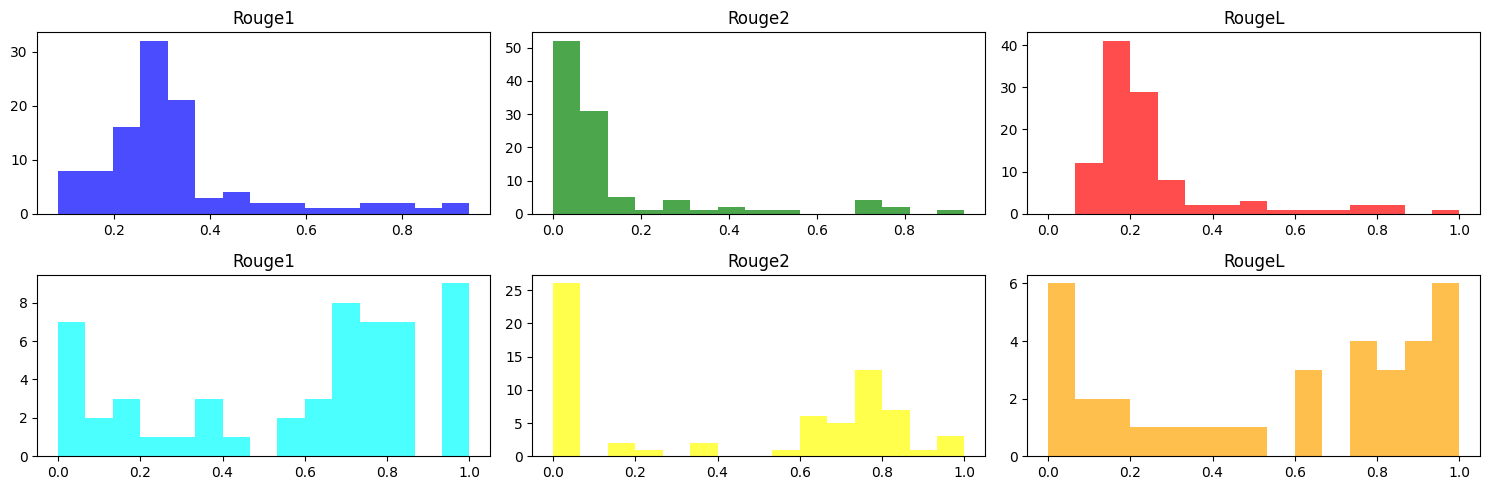

In [96]:
# On s'aperçoit que les paires rouge à haut score correspondent effectivement à des énoncés qui se répètent -> Sans clustering il est déjà possible d'avoir des résultats et en modifiant la matrice distance, il est peut-être possible d'obtenir un meilleur clustering
# Renormalisations des scores
modified_matrices = {rouge:np.zeros((n,n)) for rouge in rouges}
modified_pairs = {"rouge1":[], "rouge2":[], "rougeL":[]}

T=9

def f(x):
    return x*math.exp(-x*T)


for rouge in rouges:
    normalizer = 0
    for i in range(n):
        for j in range(i+1, n):
            value = f(rouge_matrices[rouge][i][j])
            normalizer += value
            modified_matrices[rouge][i][j] = value
            modified_matrices[rouge][j][i] = value
    modified_matrices[rouge] /= value

for rouge in rouges:
    for i in range(n):
        for j in range(i+1, n):
            result = modified_matrices[rouge][i][j]
            if result > result_threshold:
                modified_pairs[rouge].append((i,j))

print(modified_pairs)
for rouge in rouges:
    print("Pour la matrice " + rouge + ", il y a " + str(len(modified_pairs[rouge])) + " paires au-dessus du seuil de " + str(result_threshold) + ".")

rouge_list = {"rouge1":[], "rouge2":[], "rougeL":[]}
for rouge in rouges:
    for i in range(n):
            for j in range(i+1, n):
                rouge_list[rouge].append(rouge_matrices[rouge][i][j])

modified_list = {"rouge1":[], "rouge2":[], "rougeL":[]}
for rouge in rouges:
    for i in range(n):
            for j in range(i+1, n):
                modified_list[rouge].append(modified_matrices[rouge][i][j])

# Affichage des distributions de score après renormalisation
fig, axes = plt.subplots(2, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot histograms on each subplot
axes[0][0].hist(rouge_list["rouge1"], bins=15, color='blue', alpha=0.7)
axes[0][0].set_title('Rouge1')

axes[0][1].hist(rouge_list["rouge2"], bins=15, color='green', alpha=0.7)
axes[0][1].set_title('Rouge2')

axes[0][2].hist(rouge_list["rougeL"], bins=15, color='red', alpha=0.7, range=(0,1))
axes[0][2].set_title('RougeL')

axes[1][0].hist(modified_list["rouge1"], bins=15, color='cyan', alpha=0.7, range=(0,1))
axes[1][0].set_title('Rouge1')

axes[1][1].hist(modified_list["rouge2"], bins=15, color='yellow', alpha=0.7, range=(0,1))
axes[1][1].set_title('Rouge2')

axes[1][2].hist(modified_list["rougeL"], bins=15, color='orange', alpha=0.7, range=(0,1))
axes[1][2].set_title('RougeL')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [4]:

disct = {1,2}
disct.remove(1)
disct.remove(1)


KeyError: 1

In [39]:
from sklearn_extra.cluster import KMedoids
n_clusters = 10
kmedoids = KMedoids(n_clusters=n_clusters, random_state=0, metric="precomputed", max_iter=6000)
labels = kmedoids.fit_predict(rouge_matrices["rouge2"])

print(labels)

[0 8 0 5 2 0 7 8 0 0 0 3 8 9 1]


c:\Users\rayci\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
c:\Users\rayci\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
c:\Users\rayci\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
c:\Users\rayci\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cl

Plusieurs pistes: 
- Un seuil, on conserve qu'un sur 2 parmi les paires au-dessus du seuil
- La méthode des K-Medoids (algo PAM) en modifiant un peu la distribution de la matrice (loi exp, introduction de temp, xe-x)
- La méthode des K-medoids naïve
- Entraîner BERT.

In [19]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    'lmsys/vicuna-7b-v1.1',
    device_map="auto",
    trust_remote_code=True
    )

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like lmsys/vicuna-7b-v1.1 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [38]:
print("je  oui".split())

['je', 'oui']
